In [ ]:
from google.colab.patches import cv2_imshow 
from google.colab import drive 
import cv2
import numpy as np
import matplotlib.pyplot as plt

픽셀 기반의 매핑 함수를 이용하여 영상 화질 개선법

일반적인 영상 화질 향상. 픽셀r을 매핑함수M에 넣어 출력s를 얻음

s = M(r)

M은 연산자로 작용한다. M을 적용할 수 있는 여러 방법 실습이 목표

# Histogram

히스토그램은 영상안에 포함된 각각 다른 밝기값을 가진 픽셀의 분포를 보여주는 그래프

OpenCV함수중에 calcHist는 히스토그럄 전용 함수이다

cv2.calcHist(img, channels, mask, histSize, ranges[,[hist[,accumulate]])

img - unit8이나 float32유형의 소스 이미지 의미

channels - 히스토그램을 계산하는 채널의 인덱스

mask - 마스크 영상. 전체 영상의 히스토그램을 찾으려면 "None"으로 지정, 특정 영역의 히스토그램을 찾기위해 해당 영역의 마스크 영상 필요

histSize - 히스토그램 bin 개수를 나타냄. 영상 전체 색상을 나타낼 땐[256]표기

ranges - 색상 범위. 일반적으로 [0,255]표기

Mounted at /content/gdrive/


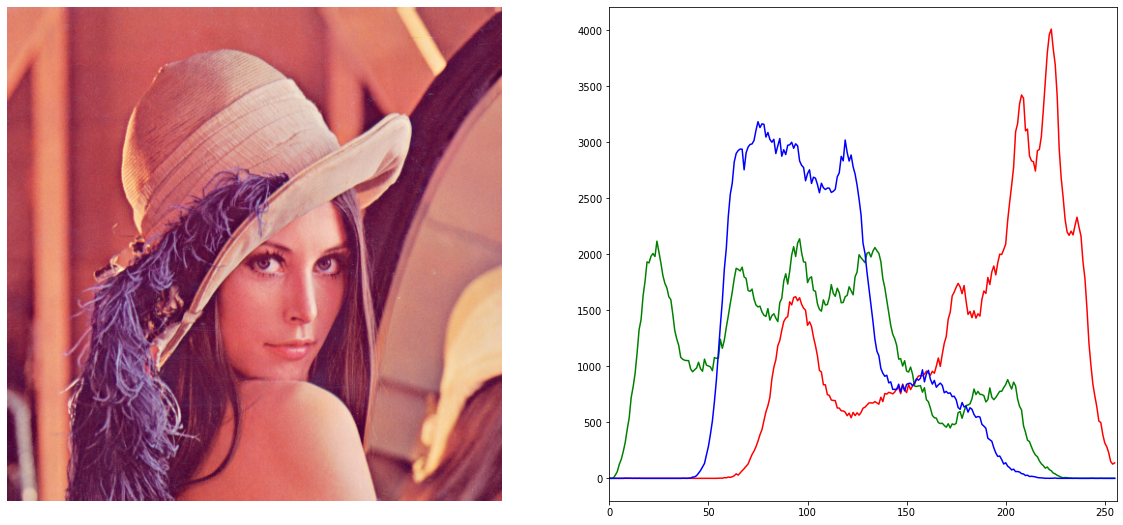

In [ ]:
drive.mount('/content/gdrive/') 

img = cv2.imread('/content/gdrive/My Drive/Image_Processing/lena.jpg')

RGB_img1 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

R_img1,G_img1,B_img1=cv2.split(RGB_img1)
plt.figure(figsize=(20,20))
plt.subplot(221), plt.imshow(RGB_img1)  #출력영상의 위치 지정 및 표시
plt.axis("off")

# 히스토그램 출력, 채널은 0으로 표시
hist = cv2.calcHist([R_img1],[0],None,[256],[0,256]) # R 색상 히스토그램 표현
plt.subplot(222),plt.plot(hist,color = 'r') # red 색상
plt.xlim([0,256]) # x축 범위
hist = cv2.calcHist([G_img1],[0],None,[256],[0,256]) # 마스크 사용없이 표현하는 히스토그램 빈은 256, x축은 0~255
plt.plot(hist,color = 'g')
plt.xlim([0,256])
hist = cv2.calcHist([B_img1],[0],None,[256],[0,256])
plt.plot(hist,color = 'b')
plt.xlim([0,256])
plt.show()


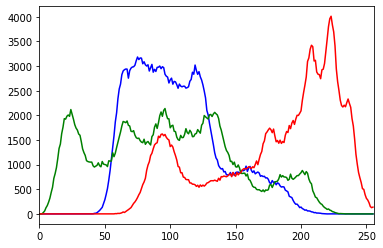

In [ ]:
# 위와 같은 결과의 다른 코드 
color = ('b','g','r')
for i,col in enumerate(color):
    histr = cv2.calcHist([img],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()

# Thresholding 임계값 적용

임계값 적용하기는 전경영역과 배경영역의 밝기 차이나 색상의 차이를 이용하여 영상의 배경에서 전경 영역을 분리할 수 있는 기초적인 방법이다

보통 검정색 픽셀이 배경, 흰색 픽셀을 전경에 해당

Thresholding 특징인 영역분할 segmentation은

하나의 임계값 파라미터를 이용, 바이너리 영상출력

만약 픽셀값 r이 임계값 T 이상일 경우는 255, 미만일 경우는 0을 출력하여 임계값에 따른 출력 픽셀값을 구함

\

임계값은 인위적으로 조작가능하고 영상에서 생성한 히스토그램으로 결정할 수도 있음


임계값 하나로 분리한 영상 분할

원본 이미지는 적혈구와 백혈구(진보라색)인데, 임계값을 140으로 설정하여 배경과 적혈구들 사이에서 백혈구를 분리시킴

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


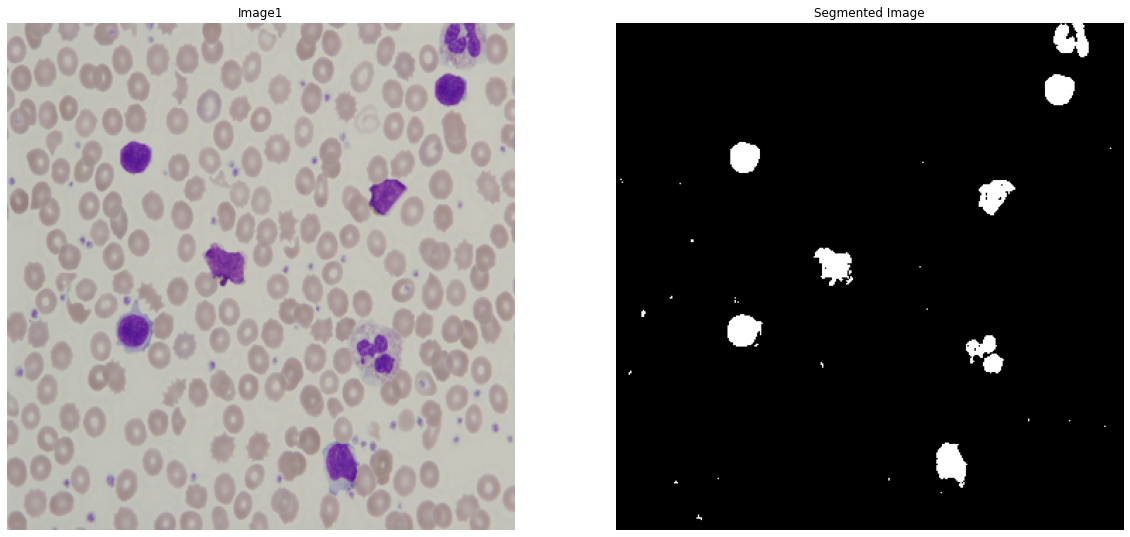

In [ ]:
drive.mount('/content/gdrive') 

img1 = cv2.imread('/content/gdrive/My Drive/Image_Processing/cell.bmp')
# BGR채널 -> RGB채널
RGB_img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB) 
# 결과 영상을 담을 배경 설정
output_img=np.zeros((RGB_img1.shape[0],RGB_img1.shape[1]))

# 임계값 140 적용 
for h in range(RGB_img1.shape[0]):
  for w in range(RGB_img1.shape[1]):
    if(np.int32(RGB_img1[h,w][0])<140):
        output_img[h,w]=255
    else:
        output_img[h,w]=0 

plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.title("Image1")
plt.imshow(RGB_img1)
plt.axis("off")
plt.subplot(1,2,2)
plt.title("Segmented Image")
plt.imshow(output_img, cmap='gray')
plt.axis("off")
plt.show()

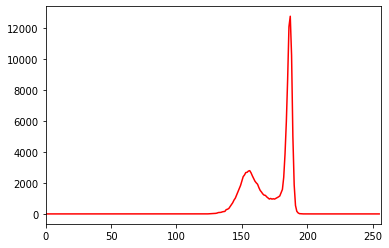

In [ ]:
# 히스토그램 분포. 2개의 봉우리 사잇값을 임계값으로 설정해 이미지 분리
for i,col in enumerate('r'):
    histr = cv2.calcHist([img1],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()

# Global Thresholding 전역 임계값 적용

임계값을 자동으로 결정하기 위한 방법

영상을 두개의 그룹으로 분할하고 각 그룹마다 평균값을 계산하여 이 값들을 임계값 계산에 적용하는 방법


> 임계값 적용 알고리즘
- 초기 임계값 T 결정
- T를 이용하여 영상 분할, 분할 결과로 그룹 2개 생성(T보다 큰 픽셀을 가진 그룹 G1, 반대그룹 G2)
- G1과 G2의 색상 평균(mean1, mean2) 계산
- 두 그룹의 평균값으로 임계값 갱신
\ T = (1/2)(mean1 + mean2)
- 이전 임계값과 새로은 임계값의 차이가 미리 정의된 파라미터 T0보다 작을 경우 영상분할 ~ 임계값 갱신 반복

전역 임계값 알고리즘에서는 종료 조건에 해당하는 T0에 따라 영상 분할 속도가 달라질 수 있다. 

즉, T0값이 작으면 최적 임계값을 추정할 수 있는 장점이 있지만 연산량이 많아 느릴 수 있다

전역 임계값으로 분리한 영상 분할

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


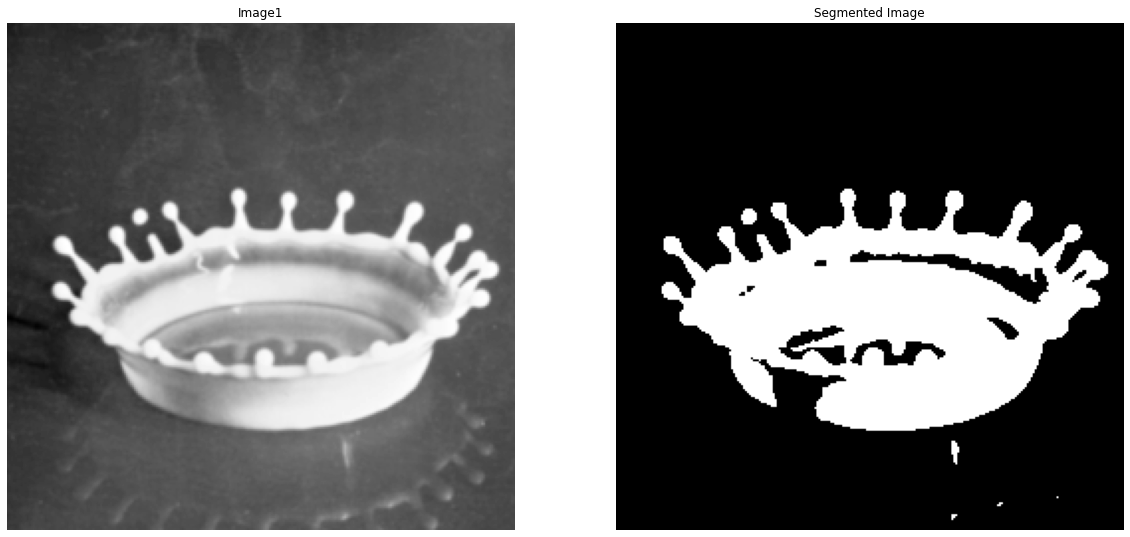

In [ ]:
drive.mount('/content/gdrive') 

img = cv2.imread('/content/gdrive/My Drive/Image_Processing/milkdrop.bmp')

# color -> gray
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

T1=50 # 초기 임계값   
T2=0 # 이전 임계값 저장 변수
T0=1 # 종료 조건 임계값 설정   

output_img =np.zeros((gray_img.shape[0],gray_img.shape[1]))

# 각 그룹별 평균값으로 새로운 임계값 계산하는 함수
def threshold_update(h, w, img, output,T1): #saturation함수 정의
   sum1=0
   count1=1
   sum2=0
   count2=1
   for h in range(img.shape[0]):
    for w in range(img.shape[1]):
      # 그룹별 픽셀 총합 계산
      if(output[h,w]==255):
         sum1 = sum1+ img[h,w]
         count1 = count1+1
    else:
        sum2 = sum2+ img[h,w]
        count2 = count2+1
   # 그룹별 픽셀 평균 계산    
   ave1 = sum1/count1 
   ave2 = sum2/count2
   # 평균으로 새로운 임계값 계산
   T2 = np.int32(ave1+ave2)/2
   return T2

#1) 영상 초기 임계값 적용 
for h in range(gray_img.shape[0]):
  for w in range(gray_img.shape[1]):
    if(gray_img[h,w]>T1):
        output_img[h,w]=255
    else:
        output_img[h,w]=0 

#2) 종료 조건을 만족할 때 까지 계속 반복
while True:
  #새로운 임계값 생성을 위한 함수 호출
  T2 = threshold_update(gray_img.shape[0], gray_img.shape[1], gray_img, output_img,T1)
  #새로운 임계값과 이전 임계값의 변화 측정
  if(np.abs(T1-T2)<T0):
    # 종료 조건을 만족하면 새로운 임계값으로 영상 이진화 후 출력
    for h in range(gray_img.shape[0]):
      for w in range(gray_img.shape[1]):
        if(gray_img[h,w]>T2):
          output_img[h,w]=255
        else:
          output_img[h,w]=0
    break
  #종료 조건을 만족하지 않는다면. 이전 임계값과 새로은 임계값의 차이가 미리 정의된 파라미터 T0보다 작을 경우 
  else:
     # 새로운 임계값으로 다시 이진화 작업
     T1 = T2
     for h in range(gray_img.shape[0]):
      for w in range(gray_img.shape[1]):
        if(gray_img[h,w]>T1):
          output_img[h,w]=255
        else:
          output_img[h,w]=0

plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.title("Image1")
plt.imshow(gray_img, cmap='gray') # gray설정이 없으면 R,G,B 중 B채널 출력
plt.axis("off")
plt.subplot(1,2,2)
plt.title("Segmented Image")
plt.imshow(output_img, cmap='gray')
plt.axis("off")
plt.show()

# Adaptive Thresholding 적응적 임계값 적용

작은 블록은 대략적으로 균등한 조명을 가질 확률이 높아 임계값 적용에 적합하다는 전제하에

영상을 블록으로 나누고 블록 내의 모든 픽셀에 동일한 임계값을 적용

전경과 배경 구분이 잘되있는 영상일 경우 임계값 하나로도 효과가 아주 좋음

그러나 조명이 불균일하거나 색이 다양한 경우는 다양한 임계값이 필요하기에 블록으로 영상 분할

\
적응적 임계값 적용에서 블록의 크기가 너무 작을 경우 과하게 세분화되어 잡음이 많아지고, 블록의 크기가 클 경우 전역적 임계값 방식과 유사.

영상의 특성과 크기에 따라 블록의 크기를 조절해야 한다



적응적 임계값으로 영상 분할

조명이 고르지 않은 영상에 임계값 적용

좌측 전역임계값 적용한 것은 조명왜곡으로 세포 일부분만 분리되고 나머지는 잘못 분리됨

우측 적응적 임계값을 각 블록마다 적용하여 상대적으로 세포영역 분리가 잘됨

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


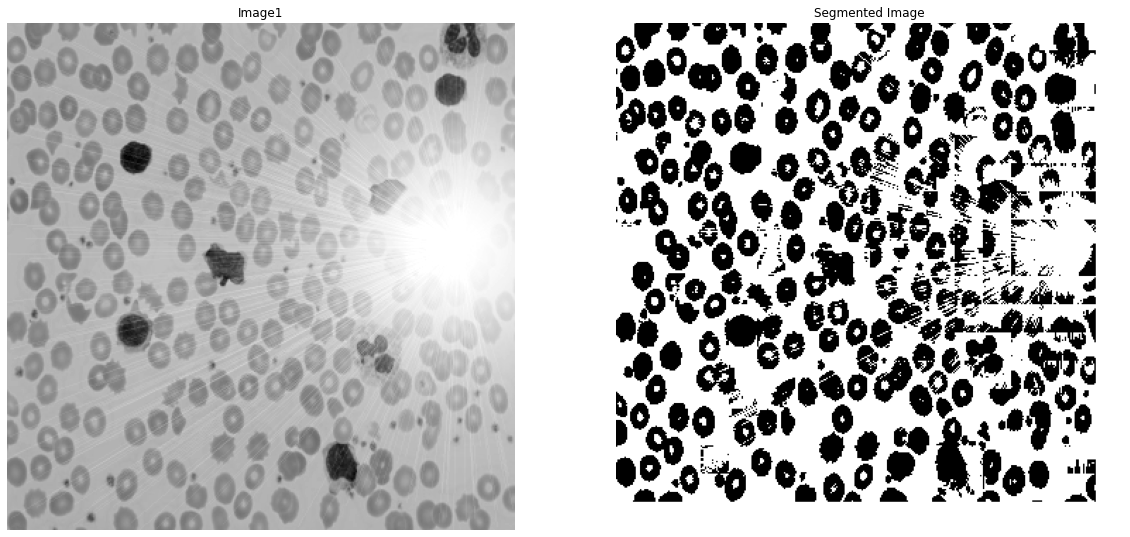

In [ ]:
drive.mount('/content/gdrive') 

img = cv2.imread('/content/gdrive/My Drive/Image_Processing/cell-bright.bmp')

# color -> gray
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#가로세로 블록의 개수 
N=18
#블록 당 가로와 세로 크기 계산 
dimh=np.int32(gray_img.shape[0]/N)
dimw=np.int32(gray_img.shape[1]/N)
#연산에서 제외될 영상 가장자리 크기 계산 
dh_rest = np.int32(gray_img.shape[0]%N) # 블록 크기보다 작은 영상의 가장자리 영역 제외
dw_rest =np.int32(gray_img.shape[1]%N)
# 임계값 적용 후 이진 영상을 담을 기억 장소 생성 
mean_img = np.zeros((N,N)) #블록의 평균값을 임시로 저장할 NxN 크기의 numpy 배열생성, 0으로 초기화
output_img = np.zeros((gray_img.shape[0],gray_img.shape[1]))

# 각 블록의 평균값 계산을 위한 함수
def mean_function(img,dimh,dimw,h,w): 
   count=1
   sum=0
   ave=0
   for y in range(h, h+dimh):
    for x in range(w, w+dimw):
       sum = sum+img[y,x]
       count = count+1
   # 블록별 픽셀 평균 계산    
   ave = np.int32(sum/count) 
   return ave

#각 블록의 평균값 계산
for h in range(0,img.shape[0]-dh_rest,dimh):
    for w in range(0,img.shape[1]-dw_rest,dimw):
         if(h+dimh <img.shape[0] and w+dimw<img.shape[1]):# 영상의 외곽을 벗어나지 않기 위한 처리
         	        mean_img[np.int32(h/dimh),np.int32(w/dimw)]= mean_function(gray_img,dimh,dimw,h,w)# 블록 배열에 평균값 배치, h/dimh로 평균 블록의 위치 설정?
 
#각 블록에 대해 임계값 적용 및 이진화 작업 수행
for h in range(0,gray_img.shape[0]-dh_rest):
  for w in range(0,gray_img.shape[1]-dw_rest):
    if(gray_img[h,w]>= mean_img[np.int32(h/dimh),np.int32(w/dimw)]):# 평균값 저장한 배열보다 영상 배열(gray_img)이 크면 255, 이외 0 설정
        output_img[h,w]=255
    else:
        output_img[h,w]=0 

plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.title("Image1")
plt.imshow(gray_img, cmap='gray')
plt.axis("off")
plt.subplot(1,2,2)
plt.title("Segmented Image")
plt.imshow(output_img, cmap='gray')
plt.axis("off")
plt.show()

# Histogram Stretching 

히스토그램 스트레칭 구현

In [ ]:
drive.mount('/content/gdrive') 

#img = cv2.imread('/content/gdrive/My Drive/Image_Processing/skin/001.jpg')
img = cv2.imread('/content/gdrive/My Drive/Image_Processing/pentagon.bmp')

# color영상을 gray영상으로 
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
output_img = np.zeros((gray_img[0],gray_img[1]))

def saturation(value):
    if(value>255):
       value = 255;
    return value 

Nmax=255
Nmin=0
max = 0
min = 255
#영상의 픽셀 중 최소값과 최대값 찾기
for h in range(img.shape[0]):
    for w in range(img.shape[1]):
        if (max < gray_img[h,w]):
            max = gray_img[h,w]
        if (min > gray_img[h,w]):
            min = gray_img[h,w]

# 최대, 최소 값을 넘어서는 픽셀들을 최소, 최대값으로 정리
for h in range(img.shape[0]):
    for w in range(img.shape[1]):
        if gray_img[h,w] < min:
           gray_img[h,w] = min
        if gray_img[h,w] > max:
           gray_img[h,w] = max

#히스토그램 스트레칭
for h in range(img.shape[0]):
    for w in range(img.shape[1]):
        output_img[h,w] = saturation(np.int32(np.float32(gray_img [h,w]-min)*np.float32((Nmax-Nmin)/(max-min))+Nmin))

print(max,min)
hist=cv2.calcHist([gray_img],[0],None,[256],[0,256])
plt.title("Histogram")
#plt.plot(hist,color='b',label='original histo')
#plt.xlim([0,256])
hist=cv2.calcHist([output_img],[0],None,[256],[0,256])
plt.plot(hist,color='g',label='streched histo')
plt.xlim([0,256])
plt.legend()

plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.title("Image1")
plt.imshow(gray_img, cmap='gray')
plt.axis("off")
plt.subplot(1,2,2)
plt.title("Streched Image")
plt.imshow(output_img, cmap='gray')
plt.axis("off")
plt.show()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


TypeError: ignored

# Histogram Equalization 히스토그램 평활화

히스토그램 평활화 구현

In [ ]:
drive.mount('/content/gdrive') 

#img = cv2.imread('/content/gdrive/My Drive/Image_Processing/facedark.jpg')
img = cv2.imread('/content/gdrive/My Drive/Image_Processing/skin/002.jpg')

# color영상을 gray영상으로 만들기
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#output_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

#히스토그램 평활화 (output_image를 따로 정의하지 말고 동적으로 생성하자)
output_img = cv2.equalizeHist(gray_img)

hist=cv2.calcHist([gray_img],[0],None,[256],[0,256])
plt.title("Histogram")
plt.plot(hist,color='b',label='original histo')
plt.xlim([0,256])
hist=cv2.calcHist([output_img],[0],None,[256],[0,256])
plt.plot(hist,color='g',label='Equalized histo')
plt.xlim([0,256])
plt.legend()

plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.title("Image1")
plt.imshow(gray_img, cmap='gray')
plt.axis("off")
plt.subplot(1,2,2)
plt.title("Equalized Image")
plt.imshow(output_img, cmap='gray')
plt.axis("off")
plt.show()